In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [2]:
np.random.seed(42) 

In [3]:
def pooling(x, kernel=2, pool='avg'):
    m, n = x.shape
    k = kernel
    mk = m // k
    nk = n // k
    
    y = np.zeros((mk, nk))
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            window = x[i*k:(i+1)*k,j*k:(j+1)*k]
            if pool == 'avg':
                y[i, j] = window.mean()
            elif pool == 'max':
                y[i, j] = window.max()

    return y

In [4]:
datapath = './data'
digit = 0
kernel = 2

data_test = MNIST(
    root = datapath, 
    train = False, 
    transform = ToTensor(),
)

x_data = [pooling(image.numpy().reshape(28, 28), kernel=kernel, pool='avg') for image, label in data_test if label==digit]
x_data = np.asarray(x_data)
x_data[x_data > .5] = 1
x_data[x_data <= .5] = 0

flatsize = (28//kernel)**2
x_data = x_data.reshape(-1, flatsize)

In [5]:
x_data.shape

(980, 196)

In [6]:

class BMM:

    """
    Class constructor
    """
    def __init__(self, n_components=2, pi=None, mu=None, alpha=0.001) -> None:

        self.n_components = n_components
        self.pi = pi
        self.mu = mu
        self.alpha = alpha

    """
    Method: _init_params

    Description: Initializes parameters
    """
    def _init_params(self, x):
        if self.pi is None:
            self.pi = np.ones(self.n_components)/self.n_components
        if self.mu is None:
            self.mu = (1-self.alpha)*np.random.rand(x.shape[1], self.n_components)+self.alpha
        return

    """
    Methods: get_params

    Returns a dictionary with all the BMM's parameters
    """
    def get_params(self) -> dict:
        return {
            'pi': self.pi.copy(),
            'mu': self.mu.copy(),
        }
            
    @staticmethod
    def compute_log_bernoulli(x, mu):
        log_prob = np.ones((x.shape[0], mu.shape[1]))
        for k in range(mu.shape[1]):
            log_prob[:, k] = np.sum(x*np.log(mu[:, k])+(1-x)*np.log(1- mu[:, k]), axis=1)
        # ALTERNATIVE WAY
        # for n in range(x.shape[0]):
        #     for k in range(mu.shape[1]):
        #         mu_k = mu[:, k]
        #         mu_neg = 1-mu_k
        #         x_n = x[n]
        #         x_neg = 1-x_n
        #         log_prob[n, k] = np.sum((x_n*np.log(mu_k))+x_neg*np.log(mu_neg))
        return log_prob

    """
    Method: _em_step

    Performs a single EM step based on the input x
    """
    def _em_step(self, x):

        # E step
        # x: shape (n, d)
        # self.pi: shape (K,)
        # self.mu: shape(d, K)
        log_prob = self.compute_log_bernoulli(x, self.mu)  # shape (n, K)
        log_scores = np.log(self.pi)[None, :] + log_prob 
        scores = np.exp(log_scores)
        responsibilities = scores/scores.sum(axis=1)[:, None]  # shape (n, K)

        # M step
        Nks = responsibilities.sum(axis=0)  # shape (K,)

        self.mu = (responsibilities[:, None, :] * x[:, :, None]).sum(axis=0) / Nks[None, :]  # shape (d, K)
        # ALTERNATIVE
        # for k in range(len(Nks)):
        #     for j in range(x.shape[1]):
        #         self.mu[j, k] = np.sum(responsibilities[:, k]*x[:, j]) / Nks[k]
        self.mu[self.mu < self.alpha] = self.alpha
        self.mu[self.mu > 1-self.alpha] = 1-self.alpha

        self.pi = Nks/Nks.sum()

        return
    

    """
    Method: fit

    Fits the Bernoulli mixture by repeating the EM steps and updating the parameters self.pi and self.mu 
    until convergence is reached

    Parameters:
    - x: Input data [shape (n, d)]
    - eps: Convergence parameter, you can try and play with it
    - max_iters: Maximum number of iterations
    - verbose: if True, prints the parameters variation at each iteration
    """
    def fit(self, x, eps=1, max_iters=100, verbose=False):

        self._init_params(x)

        converged = False
        num_iters = 0

        while (not converged):
            
            params_old = self.get_params()
            self._em_step(x)       
            params_new = self.get_params()
            
            converged = True

            for name in params_old.keys():
                # compute RMSE between old and new params
                delta = np.sqrt(np.mean((params_new[name] - params_old[name])**2))
                print(f"Variation of {name} at iter {num_iters+1:03d}: {delta}")
                if delta > eps:
                    converged = False

            num_iters += 1

            if num_iters >= max_iters:
                if verbose:
                    print("Maximum number of iterations reached: stop fitting.")
        return self

    def sample(self, n):
        idx = np.random.choice(np.arange(self.n_components), size=n, p=self.pi)  # choose the Bernoullis according to pi
        tosses = 1*(np.random.rand(n, self.mu.shape[0], self.n_components) < self.mu[None, :, :])  # toss Bernoulli coins
        return np.asarray([tosses[i, :, index] for i, index in enumerate(idx)])

In [7]:
bmm = BMM(n_components=10).fit(x_data, eps=0.1, max_iters=10, verbose=True)

Variation of pi at iter 001: 0.16698134255380218
Variation of mu at iter 001: 0.5052136581914375
Variation of pi at iter 002: 0.07274790563927469
Variation of mu at iter 002: 0.07471071468992883


In [8]:
x_sample = bmm.sample(n=10)

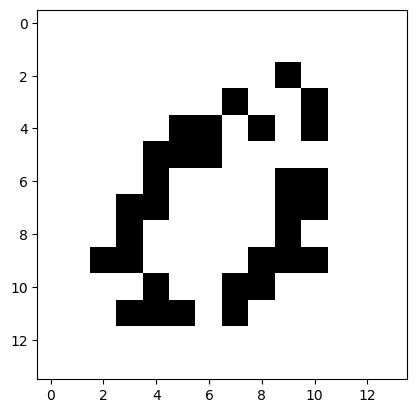

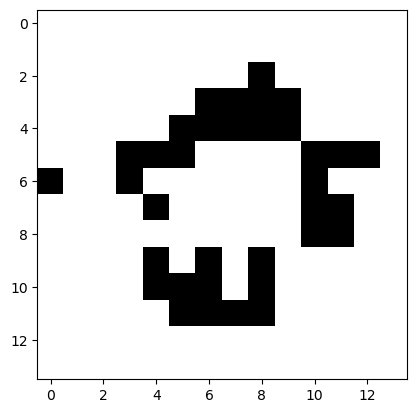

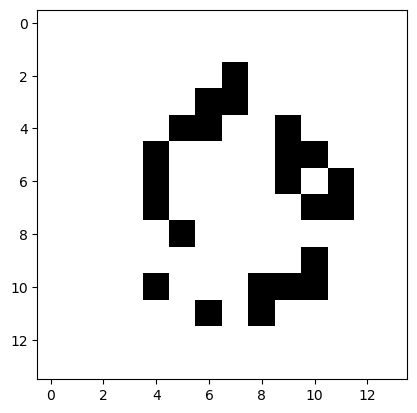

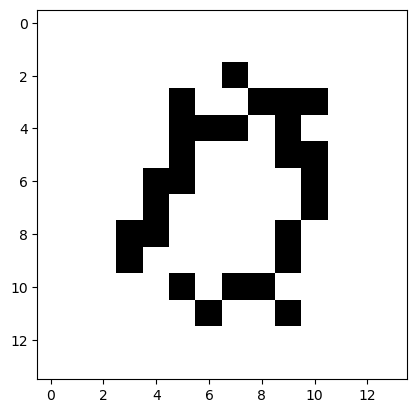

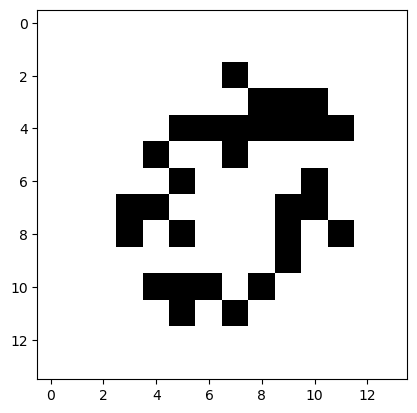

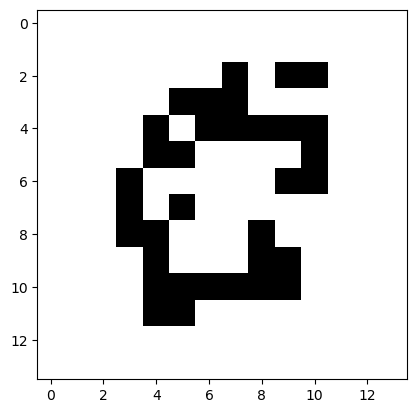

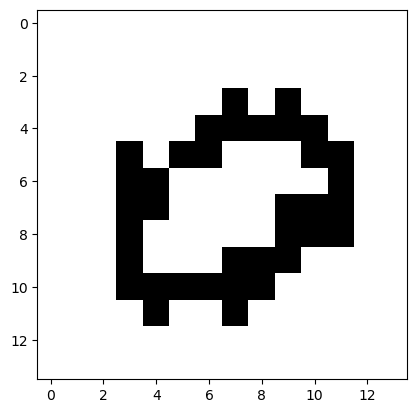

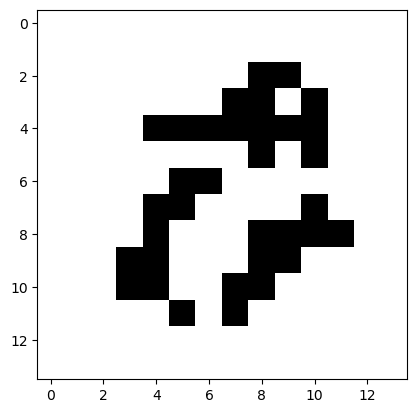

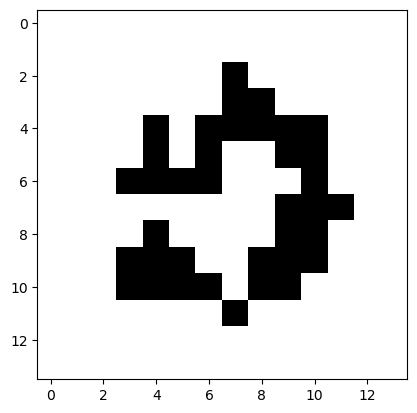

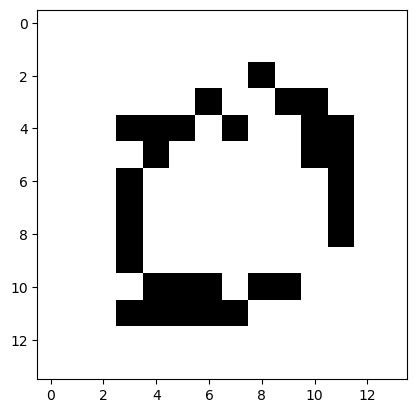

In [9]:
import os

if not os.path.isdir(f'results/{digit}'):
    os.makedirs(f'results/{digit}')

for i, x in enumerate(x_sample):
    image = x.reshape(28//kernel, 28//kernel)
    plt.figure()
    plt.imshow(image, cmap='binary')
    plt.savefig(f'results/{digit}/example_{i+1:03d}.png')
    plt.draw()